<a href="https://colab.research.google.com/github/AilingLiu/Time-Series-Python/blob/main/05_Putting_it_all_together.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import requests, zipfile, io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

r = requests.get('https://github.com/AilingLiu/Time-Series-Python/raw/main/data.zip')
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

# data files available
z.namelist()
     

['data/',
 'data/.DS_Store',
 '__MACOSX/',
 '__MACOSX/data/',
 '__MACOSX/data/._.DS_Store',
 'data/AMZN.csv',
 '__MACOSX/data/._AMZN.csv',
 'data/CME_HO1.csv',
 '__MACOSX/data/._CME_HO1.csv',
 'data/CME_NG1.csv',
 '__MACOSX/data/._CME_NG1.csv',
 'data/DJI.csv',
 '__MACOSX/data/._DJI.csv',
 'data/HRB.csv',
 '__MACOSX/data/._HRB.csv',
 'data/MSFT.csv',
 '__MACOSX/data/._MSFT.csv',
 'data/Sprint_Intraday.txt',
 '__MACOSX/data/._Sprint_Intraday.txt']

# What is cointegration?

- Two series, $P_t$ and $Q_t$ can be random walks
- But the linear combination $P_t - c Q_t$ may not be a random walk
- If that's true
  - $P_t - c Q_t$ is forecastable
  - $P_t$ and $Q_t$ are said to be cointegrated


Two Steps to test for cointegration

- regress $P_t$ on $Q_t$ and get slope $c$
- run Augmented Dickey-Fuller test on $P_t - c Q_t$ to test for random walk
- alternatively, can use `coint` function in statsmodels that combines both steps

```
from statsmodels.tsa.stattools import coint
coint(P,Q)
```

In [2]:
HO = pd.read_csv('data/CME_HO1.csv', sep=',', index_col='Date')
HO.index=pd.to_datetime(HO.index)
HO.head()

,Close
Date,
2005-12-30,1.7280
2005-12-29,1.7030
2005-12-28,1.6825
2005-12-27,1.6370
2005-12-23,1.7053


In [3]:
NG = pd.read_csv('data/CME_NG1.csv', sep=',', index_col='Date')
NG.index=pd.to_datetime(NG.index)
NG.head()

,Close
Date,
2005-12-30,11.225
2005-12-29,11.223
2005-12-28,11.431
2005-12-27,11.022
2005-12-23,12.283


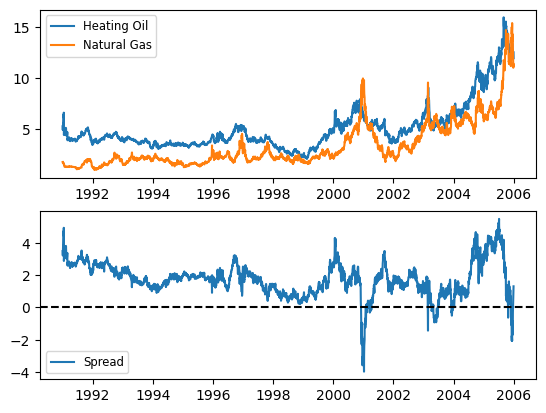

In [5]:
# we multiply the heating oil prices, in $/gallon, by 7.25, which converts it to $/millionBTU, which is the same units as Natural Gas
# Plot the prices separately
plt.subplot(2,1,1)
plt.plot(7.25*HO, label='Heating Oil')
plt.plot(NG, label='Natural Gas')
plt.legend(loc='best', fontsize='small')

# Plot the spread
plt.subplot(2,1,2)
plt.plot(7.25*HO-NG, label='Spread')
plt.legend(loc='best', fontsize='small')
plt.axhline(y=0, linestyle='--', color='k')
plt.show()


Notice from the plot that when Heating Oil briefly dipped below Natural Gas, it quickly reverted back up.

# Verify cointegration

To verify that Heating Oil and Natural Gas prices are cointegrated, First apply the Dickey-Fuller test separately to show they are random walks. Then apply the test to the difference, which should strongly reject the random walk hypothesis. 

In [6]:
# Import the adfuller module from statsmodels
from statsmodels.tsa.stattools import adfuller

# Compute the ADF for HO and NG
result_HO = adfuller(HO['Close'])
print("The p-value for the ADF test on HO is ", result_HO[1])
result_NG = adfuller(NG['Close'])
print("The p-value for the ADF test on NG is ", result_NG[1])

# Compute the ADF of the spread
result_spread = adfuller(7.25 * HO['Close'] - NG['Close'])
print("The p-value for the ADF test on the spread is ", result_spread[1])

The p-value for the ADF test on HO is  0.019831028071627798
The p-value for the ADF test on NG is  0.004547284956542362
The p-value for the ADF test on the spread is  0.00011887051827353092


As we expected, we cannot reject the hypothesis that the individual futures are random walks, but we can reject that the spread is a random walk.

Cointegration involves two steps: regressing one time series on the other to get the cointegration vector, and then perform an ADF test on the residuals of the regression. In the last example, there was no need to perform the first step since we implicitly assumed the cointegration vector was 
. In other words, we took the difference between the two series (after doing a units conversion). Here, you will do both steps.

In [7]:
# Import the statsmodels module for regression and the adfuller function
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Regress BTC on NG
NG = sm.add_constant(NG)
result = sm.OLS(HO,NG).fit()

# Compute ADF
b = result.params[1]
adf_stats = adfuller(HO['Close'] - b*NG['Close'])
print("The p-value for the ADF test is ", adf_stats[1])

The p-value for the ADF test is  0.0005467677716962234


In [8]:
b

0.12695129612293785

The data suggests that heating oil and natural gas are cointegrated.

# Case Study: climate change

Analyzing Temperature Data 
- Test for Random Walk 
- Take first differences
- Compute ACF and PACF 
- Fit a few AR, MA and ARMA models  
- Use Information Criterion to choose best model 
- Forecast temperature over next 30 years

In [9]:
temp_NY = pd.read_csv('https://assets.datacamp.com/production/repositories/1120/datasets/850e5614f8de4b134f40b4eeca27c7d0b91aeed2/NOAA_TAVG.csv', 
                      sep=',', index_col='DATE')

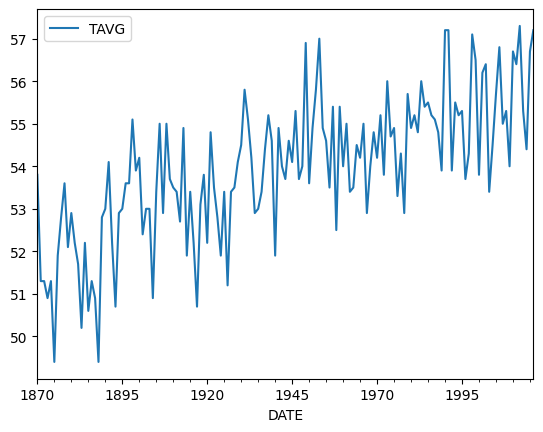

The p-value for the ADF test is  0.5832938987871145


In [12]:
# Import the adfuller function from the statsmodels module
from statsmodels.tsa.stattools import adfuller

# Convert the index to a datetime object
temp_NY.index = pd.to_datetime(temp_NY.index, format='%Y')

# Plot average temperatures
temp_NY.plot()
plt.show()

# Compute and print ADF p-value
result = adfuller(temp_NY['TAVG'])
print("The p-value for the ADF test is ", result[1])

The data seems to follow a random walk with drift.

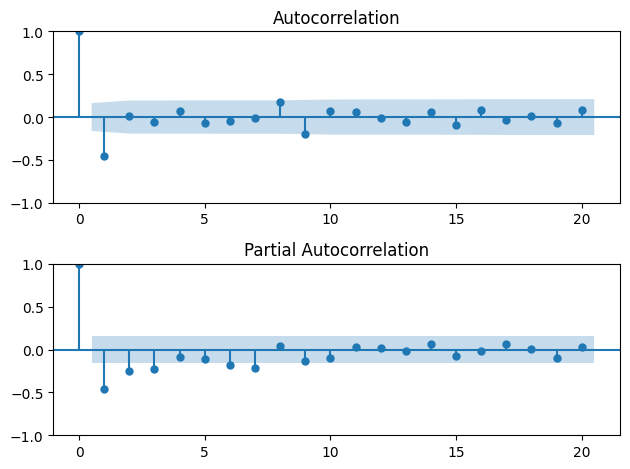

In [15]:
# Import the modules for plotting the sample ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Take first difference of the temperature Series
chg_temp = temp_NY.diff()
chg_temp = chg_temp.dropna()

# Plot the ACF and PACF on the same page
fig, axes = plt.subplots(2,1)

# Plot the ACF
plot_acf(chg_temp, lags=20, ax=axes[0])

# Plot the PACF
plot_pacf(chg_temp, lags=20, ax=axes[1],method='ywm')
plt.tight_layout()
plt.show()

There is no clear pattern in the ACF and PACF except the negative lag-1 autocorrelation in the ACF.

# Which ARMA Model is Best?

Recall from Chapter 3 that the Akaike Information Criterion (AIC) can be used to compare models with different numbers of parameters. It measures goodness-of-fit, but places a penalty on models with more parameters to discourage overfitting. Lower AIC scores are better.

Fit the temperature data to an AR(1), AR(2), and ARMA(1,1) and see which model is the best fit, using the AIC criterion. The AR(2) and ARMA(1,1) models have one more parameter than the AR(1) has.

Which ARMA Model is Best?


In [18]:
# Import the module for estimating an ARIMA model
from statsmodels.tsa.arima.model import ARIMA

# Fit the data to an AR(1) model and print AIC:
mod_ar1 = ARIMA(chg_temp, order=(1, 0, 0))
res_ar1 = mod_ar1.fit()
print("The AIC for an AR(1) is: ", res_ar1.aic)

# Fit the data to an AR(2) model and print AIC:
mod_ar2 = ARIMA(chg_temp, order=(2, 0, 0))
res_ar2 = mod_ar2.fit()
print("The AIC for an AR(2) is: ", res_ar2.aic)

# Fit the data to an ARMA(1,1) model and print AIC:
mod_arma11 = ARIMA(chg_temp, order=(1,0, 1))
res_arma11 = mod_arma11.fit()
print("The AIC for an ARMA(1,1) is: ", res_arma11.aic)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be use

The AIC for an AR(1) is:  510.53468987331087
The AIC for an AR(2) is:  501.9274123409139


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


The AIC for an ARMA(1,1) is:  469.07292032850296


The ARMA(1,1) has the lowest AIC values among the three models.

Finally, you will forecast the temperature over the next 30 years using an ARMA(1,1) model, including confidence bands around that estimate. Keep in mind that the estimate of the drift will have a much bigger impact on long range forecasts than the ARMA parameters.

Earlier, you determined that the temperature data follows a random walk and you looked at first differencing the data. In this exercise, you will use the ARIMA module on the temperature data (before differencing), which is identical to using the ARMA module on changes in temperature, followed by taking cumulative sums of these changes to get the temperature forecast.

Because temperatures are trending up over time, you will also need to add a trend component when you define the ARIMA model. In the exercise, you'll use a linear trend with time by setting the argument trend='t'. You can also try other trend models to see how the forecasts change. For example, for a quadratic trend $a+bt+ct^2$, set trend=[0,1,1], to include both a linear term, $bt$, and quadratic term, $ct^2$, in the model.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


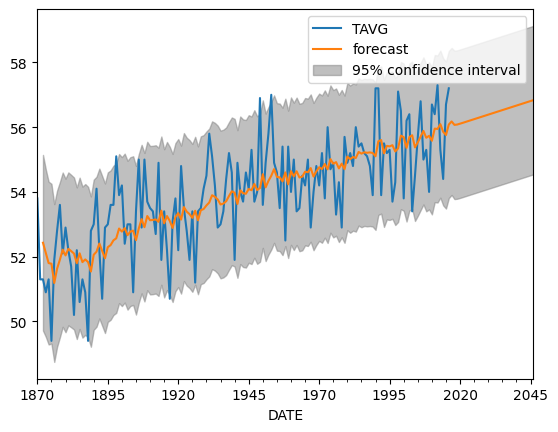

In [19]:
# Import the ARIMA module from statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

# Forecast temperatures using an ARIMA(1,1,1) model
mod = ARIMA(temp_NY, trend='t', order=(1,1,1))
res = mod.fit()

# Plot the original series and the forecasted series
fig, ax = plt.subplots()
temp_NY.plot(ax=ax)
plot_predict(res, start='1872', end='2046', ax=ax)
plt.show()

According to the model, the temperature is expected to be about 0.6 degrees higher in 30 years (almost entirely due to the trend), but the 95% confidence interval around that is over 5 degrees.